#### CIE-Project B || Group - 7

#### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import resample, find_peaks
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle
import time

# from sklearn import preprocessing ##importing for normalization
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, LSTM, CuDNNLSTM
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.frameon'] = True
# plt.rcParams['figure.figsize'] = (8, 8)
%matplotlib widget

##### Get the root directory and change to it

In [2]:
rootdir = os.getcwd()
os.chdir(rootdir)

#### Folder Variables Assignment

In [3]:
# Names of the folders
Training_Folder = 'EPOT_DATA'
Validation_Aug_Folder = 'Validation_augmented_data'
Experiment = 'Experiment'
Ex_Validation = 'Experimental_validation'

counter = 0

#### Parsing

##### Parse training and validation-augmented data

In [4]:
# Initialize lists for training and validation
training_tr = []; training_tr_labels = []

validation_aug = []; validation_aug_labels = [] # validation augmented data

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Training_Folder.lower() in subdir.lower():
        for file in files:
            if file.endswith('.mat'):
                lbl = [file.split('_')[1], file.split('_')[2][:3]]
                lb = np.asarray(lbl, dtype=float)
                # load mat-file
                mat = loadmat(os.path.join(subdir, file))
                # get the numpy data from the mat file
                mat = mat['num_data']
                # append data to the list
                training_tr.append(mat)
                training_tr_labels.append(lb)

    elif Validation_Aug_Folder.lower() in subdir.lower():
        for file in files:
            if file.endswith('.mat'):
                lbl = [file.split('_')[1], file.split('_')[2][:3]]
                lb = np.asarray(lbl, dtype=float)
                # load mat-file
                mat = loadmat(os.path.join(subdir, file))
                # get the numpy data from the mat file
                mat = mat['num_data']
                # append data to the list
                validation_aug.append(mat)
                validation_aug_labels.append(lb)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
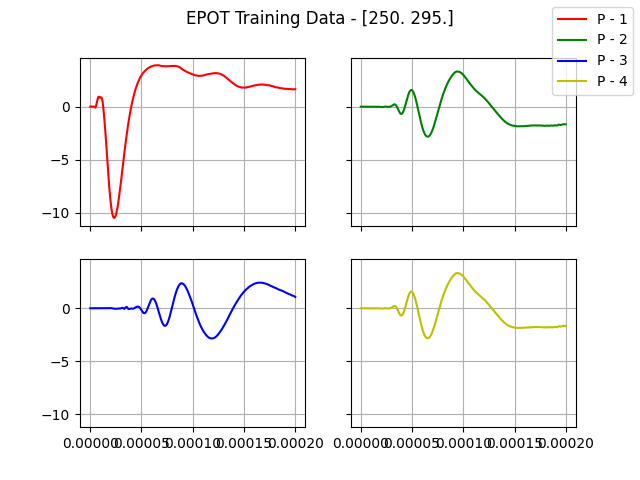

In [5]:
plt.close()
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

l = 6

fig.suptitle(f'EPOT Training Data - {training_tr_labels[l]}')

axs[0,0].plot(training_tr[l][:,0], training_tr[l][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training_tr[l][:,0], training_tr[l][:,2], label='P - 2', c = 'g')
axs[1,0].plot(training_tr[l][:,0], training_tr[l][:,3], label='P - 3', c = 'b')
axs[1,1].plot(training_tr[l][:,0], training_tr[l][:,4], label='P - 4', c = 'y')

fig.legend()
plt.show()

##### Parse, Cut, Normalize, and Resample the experimental data

In [6]:
# Initialize lists for training and validation
ex_data = []; ex_labels = []

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Experiment.lower() in subdir.lower():
        for file in files:
            if file.endswith('.txt'):
                
                with open(os.path.join(subdir, file), 'r') as f:
                    x = pd.read_csv(os.path.join(subdir, file), delimiter='\t', decimal=',', skiprows=8, header=None)
                    x = np.asarray(x, dtype=float)
                    ex_data.append(x)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
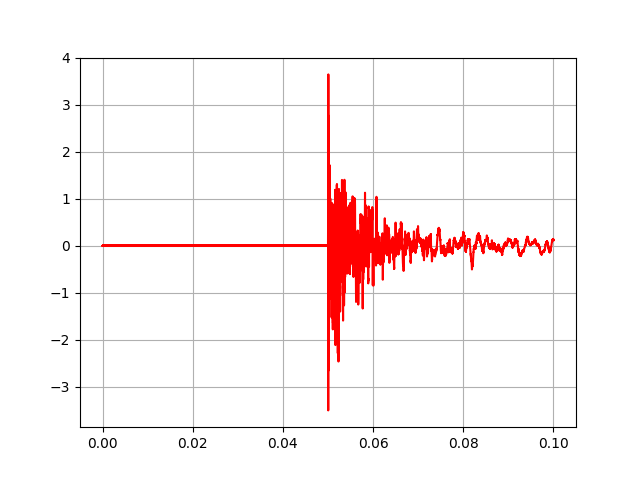

In [7]:
plt.close()
l = 5
plt.plot(ex_data[l][:,0], ex_data[l][:,1], label='P - 1', c = 'r')
plt.show()

In [8]:
ex_cut_data=[]
for i in range(0,len(ex_data)):

    data = ex_data[i]
    start_time = 0.04996
    end_time = 0.05016

    start=np.where(data==(start_time))
    end = np.where(data==(end_time))
    
    d = np.zeros(((200),5))

    d[:,0]=ex_data[i][start[0][0]:start[0][0]+200,0]
    d[:,1]=ex_data[i][start[0][0]:start[0][0]+200,1]
    d[:,2]=ex_data[i][start[0][0]:start[0][0]+200,2]
    d[:,3]=ex_data[i][start[0][0]:start[0][0]+200,4]
    d[:,4]=ex_data[i][start[0][0]:start[0][0]+200,3]

    # append data to a numpy array
    ex_cut_data.append(d)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
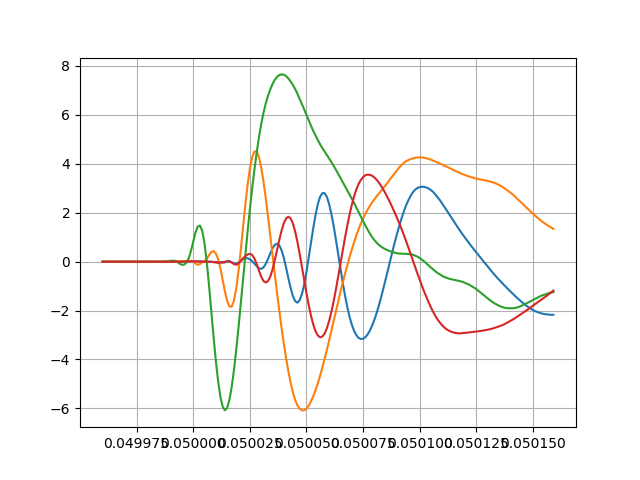

In [9]:
plt.close()
l = 4
plt.plot(ex_cut_data[l][:,0], ex_cut_data[l][:,1], label='P - 1')
plt.plot(ex_cut_data[l][:,0], ex_cut_data[l][:,2], label='P - 2')
plt.plot(ex_cut_data[l][:,0], ex_cut_data[l][:,3], label='P - 3')
plt.plot(ex_cut_data[l][:,0], ex_cut_data[l][:,4], label='P - 4')
plt.show()

Normalize and Resample experimental data

In [10]:
# create variables for normalized data
ex_norm = np.zeros_like(np.asarray(ex_cut_data))

for i in range (0, len(ex_cut_data)):
    for j in range (1, 5):
        ex_norm[i][:,j] = minmax_scale(ex_cut_data[i][:,j])

In [11]:
ex_resample = []

# create a dataframe from the normalized data
for i in range (0, len(ex_norm)):
    ex_resample.append(pd.DataFrame(ex_norm[i], columns = ['time', '1', '2', '3', '4']))
    # drop the time column
    ex_resample[i] = ex_resample[i].drop(columns = ['time'])

size = 100

for i in range (0, len(ex_resample)):
    ex_resample[i] = resample(ex_resample[i], size)

np.asarray(ex_resample).shape

(42, 100, 4)

##### Parse, Cut, Normalize, and Resample the experimental validation data

In [12]:
# Initialize lists for training and validation
ex_val_data = []; ex_val_labels = []

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Ex_Validation.lower() in subdir.lower():
        for file in files:
            if file.endswith('.txt'):
                
                with open(os.path.join(subdir, file), 'r') as f:
                    # print(file.split('_')[2], file.split('_')[3], file.split('_')[5][:3])
                    lbl = [file.split('_')[2], file.split('_')[3], file.split('_')[5][:3]]
                    lb = np.asarray(lbl, dtype=float)

                    x = pd.read_csv(os.path.join(subdir, file), delimiter='\t', decimal=',', skiprows=8, header=None)
                    x = np.asarray(x, dtype=float)
                    ex_val_data.append(x)
                    ex_val_labels.append(lb)


ex_val_trails = np.asarray(ex_val_labels)[:,2]
ex_val_labels = np.delete(ex_val_labels, 2, 1)

In [13]:
# ex_val_cut_data=[]
# for i in range(0,len(ex_val_data)):
#     data=ex_data[i][:,0]
    
#     start_time = 0.04996
#     end_time = 0.05016
#     start=np.where(data==(start_time))
#     end = np.where(data==(end_time))
    
#     d = np.zeros(((start[0][0]+200-start[0][0]),5))

#     d[:,0]=ex_val_data[i][start[0][0]:start[0][0]+200,0]
#     d[:,1]=ex_val_data[i][start[0][0]:start[0][0]+200,1]
#     d[:,2]=ex_val_data[i][start[0][0]:start[0][0]+200,2]
#     d[:,3]=ex_val_data[i][start[0][0]:start[0][0]+200,4]
#     d[:,4]=ex_val_data[i][start[0][0]:start[0][0]+200,3]
    
#     ex_val_cut_data.append(d)
#----------------------------------------------------------------------------------------


ex_val_cut_data = []
for i in range(len(ex_val_data)):
    
    x = np.where(abs(ex_val_data[i][:,1])>0.05)[0][0]
    y = np.where(abs(ex_val_data[i][:,2])>0.05)[0][0]
    z = np.where(abs(ex_val_data[i][:,3])>0.05)[0][0]
    p = np.where(abs(ex_val_data[i][:,4])>0.05)[0][0]

    start = min(x,y,z,p)
    end = start+200

    d = np.empty_like(ex_val_data[i][start:end,:])

    d[:,0] = ex_val_data[i][start:end, 0]
    d[:,1] = ex_val_data[i][start:end, 1]
    d[:,2] = ex_val_data[i][start:end, 2]
    d[:,3] = ex_val_data[i][start:end, 4]
    d[:,4] = ex_val_data[i][start:end, 3]

    ex_val_cut_data.append(d)

Normalize and Resample experimental validation data

In [14]:
# create variables for normalized data
ex_val_norm = np.zeros_like(np.asarray(ex_val_cut_data)); ex_val_norm_labels = np.zeros_like(np.asarray(ex_val_cut_data))

for i in range (0, len(ex_val_cut_data)):
    for j in range (1, 5):
        ex_val_norm[i][:,j] = minmax_scale(ex_val_cut_data[i][:,j])

scalar = MinMaxScaler()
ex_val_norm_labels = scalar.fit_transform(ex_val_labels)

In [15]:
ex_val_resample = []

# create a dataframe from the normalized data
for i in range (0, len(ex_val_norm)):
    ex_val_resample.append(pd.DataFrame(ex_val_norm[i], columns = ['time', '1', '2', '3', '4']))
    # drop the time column
    ex_val_resample[i] = ex_val_resample[i].drop(columns = ['time'])

size = 100

for i in range (0, len(ex_val_resample)):
    ex_val_resample[i] = resample(ex_val_resample[i], size)

np.asarray(ex_val_resample).shape

(24, 100, 4)

#### Augmentation

##### Variable initialization

In [16]:
## -----------------------------------------------------------------------------
#Assuming P1 on top and counter clockwise order
## -----------------------------------------------------------------------------


# Variables for the augmented data
training_tl = np.zeros_like(np.asarray(training_tr)); training_tl_labels = np.zeros_like(np.asarray(training_tr_labels))
training_bl = np.zeros_like(np.asarray(training_tr)); training_bl_labels = np.zeros_like(np.asarray(training_tr_labels))
training_br = np.zeros_like(np.asarray(training_tr)); training_br_labels = np.zeros_like(np.asarray(training_tr_labels))

##### Top-Left

In [17]:
for i in range (0, len(training_tr)):
        training_tl[i][:,0] = training_tr[i][:,0]
        training_tl[i][:,1] = training_tr[i][:,1]
        training_tl[i][:,2] = training_tr[i][:,4]
        training_tl[i][:,3] = training_tr[i][:,3]
        training_tl[i][:,4] = training_tr[i][:,2]

for i in range (0, len(training_tl_labels)):
    training_tl_labels[i][0] = 500 - training_tr_labels[i][0]
    training_tl_labels[i][1] = training_tr_labels[i][1]

##### Bottom-Left

In [18]:
for i in range (0, len(training_bl)):
    training_bl[i][:,0] = training_tl[i][:,0]
    training_bl[i][:,1] = training_tl[i][:,3]
    training_bl[i][:,2] = training_tl[i][:,2]
    training_bl[i][:,3] = training_tl[i][:,1]
    training_bl[i][:,4] = training_tl[i][:,4]

for i in range (0, len(training_bl_labels)):
    training_bl_labels[i][0] = 500. - training_tr_labels[i][0]
    training_bl_labels[i][1] = 500. - training_tr_labels[i][1]

##### Bottom-Right

In [19]:
for i in range (0, len(training_br)):
        training_br[i][:,0] = training_bl[i][:,0]
        training_br[i][:,1] = training_bl[i][:,1]
        training_br[i][:,2] = training_bl[i][:,4]
        training_br[i][:,3] = training_bl[i][:,3]
        training_br[i][:,4] = training_bl[i][:,2]

for i in range (0, len(training_br_labels)):
    training_br_labels[i][0] = training_tr_labels[i][0]
    training_br_labels[i][1] = 500 - training_tr_labels[i][1]

##### Delete overlapping data points

In [20]:
training_tl = np.delete(np.asarray(training_tl), np.where(np.asanyarray(training_tl_labels) == 250.)[0], axis = 0)
training_tl_labels = np.delete(np.asarray(training_tl_labels), np.where(np.asanyarray(training_tl_labels) == 250.)[0], axis = 0)

training_bl = np.delete(np.asarray(training_bl), 0, axis = 0)
training_bl_labels = np.delete(np.asarray(training_bl_labels), 0, axis = 0)

training_br = np.delete(np.asarray(training_br), np.where(np.asanyarray(training_br_labels) == 250.)[0], axis = 0)
training_br_labels = np.delete(np.asarray(training_br_labels), np.where(np.asanyarray(training_br_labels) == 250.)[0], axis = 0)

##### Makesure the augmentation is done on all quadrants

In [21]:
print(f'{np.asarray(training_tl).shape} \t{np.asarray(training_tr).shape} \n{np.asarray(training_bl).shape} \t{np.asarray(training_br).shape} \n{counter}')

(219, 20000, 5) 	(244, 20000, 5) 
(243, 20000, 5) 	(219, 20000, 5) 
0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
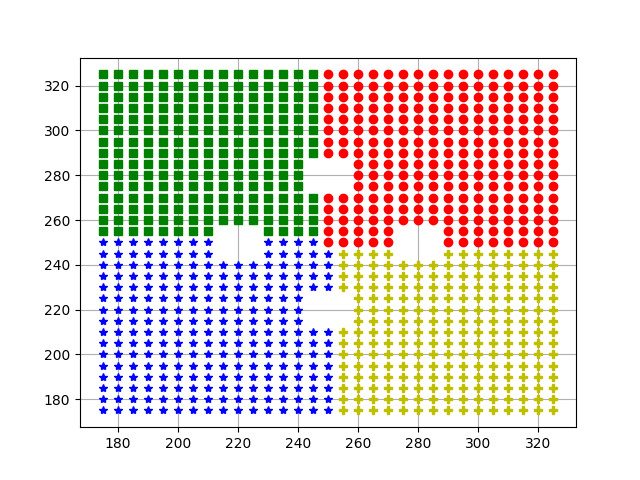

In [22]:
plt.close()
for i in range(0, len(training_tr_labels)):
    plt.plot(training_tr_labels[i][0], training_tr_labels[i][1], 'o', c = 'r')
for j in range (0, len(training_tl_labels)):
    plt.plot(training_tl_labels[j][0], training_tl_labels[j][1], 's', c = 'g')
    plt.plot(training_br_labels[j][0], training_br_labels[j][1], 'P', c = 'y')
for k in range (0, len(training_bl_labels)):
    plt.plot(training_bl_labels[k][0], training_bl_labels[k][1], '*', c = 'b')            

plt.show()

#### Concatenate, Cut, Normalize, Resample Training Data

##### Concatenate

In [23]:
training = np.concatenate((training_tr, training_tl, training_bl, training_br), axis = 0)
training_labels = np.concatenate((training_tr_labels, training_tl_labels, training_bl_labels, training_br_labels), axis = 0)

print(f'Shape of all training set: {training.shape} \nShape of all training labels: {training_labels.shape}')

Shape of all training set: (925, 20000, 5) 
Shape of all training labels: (925, 2)


##### check with the validation augmented data

Data is augmented correctly
Data is augmented correctly
Data is augmented correctly


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
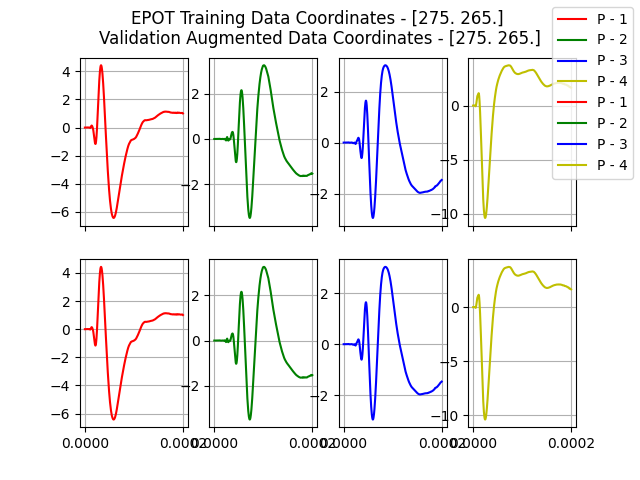

In [24]:
plt.close()
fig, axs = plt.subplots(2, 4, sharex=True)

val_c = 3 # Given validation folder has 4 data points. so use - (0, 1, 2, 3)

# find out the index of the validation set in the training data
x = []
for i in range (0, len(training_labels)):
    if (training_labels[i][0] == validation_aug_labels[val_c][0]) and (training_labels[i][1] == validation_aug_labels[val_c][1]):
        x.append(i)

# plot to compare the validation set with the training set
fig.suptitle(f'EPOT Training Data Coordinates - {training_labels[x[0]]} \nValidation Augmented Data Coordinates - {validation_aug_labels[val_c]}')

axs[0,0].plot(training[x[0]][:,0], training[x[0]][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training[x[0]][:,0], training[x[0]][:,2], label='P - 2', c = 'g')
axs[0,2].plot(training[x[0]][:,0], training[x[0]][:,3], label='P - 3', c = 'b')
axs[0,3].plot(training[x[0]][:,0], training[x[0]][:,4], label='P - 4', c = 'y')

axs[1,0].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,1], label='P - 1', c = 'r')
axs[1,1].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,2], label='P - 2', c = 'g')
axs[1,2].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,3], label='P - 3', c = 'b')
axs[1,3].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,4], label='P - 4', c = 'y')

# check if the data is exactly the same
for i in range (1, 5):
    if np.all(training[x[0]][:,i] == validation_aug[val_c][:,i], axis = 0):
        print('Data is augmented correctly')

fig.legend()
plt.show()

In [25]:
diff = training[x[0]][:,1] - validation_aug[val_c][:,1]
diff

array([0., 0., 0., ..., 0., 0., 0.])

##### -- Check -- for outliers

In [26]:
'''
plt.close()
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

for i in range(len(training)):
    axs[0,0].plot(training[i][:,0], training[i][:,1], label='Training P-1')
    axs[0,1].plot(training[i][:,0], training[i][:,2], label='Training P-2')
    axs[1,0].plot(training[i][:,0], training[i][:,3], label='Training P-3')
    axs[1,1].plot(training[i][:,0], training[i][:,4], label='Training P-4')

plt.show()
'''

"\nplt.close()\nfig, axs = plt.subplots(2, 2, sharex=True, sharey=True)\n\nfor i in range(len(training)):\n    axs[0,0].plot(training[i][:,0], training[i][:,1], label='Training P-1')\n    axs[0,1].plot(training[i][:,0], training[i][:,2], label='Training P-2')\n    axs[1,0].plot(training[i][:,0], training[i][:,3], label='Training P-3')\n    axs[1,1].plot(training[i][:,0], training[i][:,4], label='Training P-4')\n\nplt.show()\n"

In [27]:
'''
%matplotlib inline
sns.set(rc={'figure.figsize':(30, 30)})

x = []; y = []; z = []

for i in range(len(training)):
    xi = training_labels[i][0]
    x.append(xi)
    yi = training_labels[i][1]
    y.append(yi)
    zi = pd.DataFrame(training[i][:,1]).max()[0]
    # zi = pd.DataFrame(training[i][:,2]).max()[0]
    # zi = pd.DataFrame(training[i][:,3]).max()[0]
    # zi = pd.DataFrame(training[i][:,4]).max()[0]

    z.append(zi)

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

heatmap1_data = pd.pivot_table(df, values='z', index=['y'], columns='x')

ax = sns.heatmap(heatmap1_data, 
                square=True, 
                annot = True, 
                annot_kws={"fontsize": 10}, 
                fmt='.1f', 
                linewidths=0.1, 
                linecolor='gray',
                cbar_kws = dict(use_gridspec=False, location='right'))

ax.invert_yaxis()
'''

'\n%matplotlib inline\nsns.set(rc={\'figure.figsize\':(30, 30)})\n\nx = []; y = []; z = []\n\nfor i in range(len(training)):\n    xi = training_labels[i][0]\n    x.append(xi)\n    yi = training_labels[i][1]\n    y.append(yi)\n    zi = pd.DataFrame(training[i][:,1]).max()[0]\n    # zi = pd.DataFrame(training[i][:,2]).max()[0]\n    # zi = pd.DataFrame(training[i][:,3]).max()[0]\n    # zi = pd.DataFrame(training[i][:,4]).max()[0]\n\n    z.append(zi)\n\ndf = pd.DataFrame({\'x\': x, \'y\': y, \'z\': z})\n\nheatmap1_data = pd.pivot_table(df, values=\'z\', index=[\'y\'], columns=\'x\')\n\nax = sns.heatmap(heatmap1_data, \n                square=True, \n                annot = True, \n                annot_kws={"fontsize": 10}, \n                fmt=\'.1f\', \n                linewidths=0.1, \n                linecolor=\'gray\',\n                cbar_kws = dict(use_gridspec=False, location=\'right\'))\n\nax.invert_yaxis()\n'

Experimental Validation

In [28]:
'''
%matplotlib inline
sns.set(rc={'figure.figsize':(30, 30)})

x = []; y = []; z = []

for i in range(len(ex_val_data)):
    xi = ex_val_labels[i][0]
    x.append(xi)
    yi = ex_val_labels[i][1]
    y.append(yi)
    zi = pd.DataFrame(ex_val_data[i][:,1]).max()[0]
    # zi = pd.DataFrame(training[i][:,2]).max()[0]
    # zi = pd.DataFrame(training[i][:,3]).max()[0]
    # zi = pd.DataFrame(training[i][:,4]).max()[0]

    z.append(zi)

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

heatmap1_data = pd.pivot_table(df, values='z', index=['y'], columns='x')

ax = sns.heatmap(heatmap1_data, 
                square=True, 
                annot = True, 
                annot_kws={"fontsize": 10}, 
                fmt='.1f', 
                linewidths=0.1, 
                linecolor='gray',
                cbar_kws = dict(use_gridspec=False, location='right'))

ax.invert_yaxis()
'''

'\n%matplotlib inline\nsns.set(rc={\'figure.figsize\':(30, 30)})\n\nx = []; y = []; z = []\n\nfor i in range(len(ex_val_data)):\n    xi = ex_val_labels[i][0]\n    x.append(xi)\n    yi = ex_val_labels[i][1]\n    y.append(yi)\n    zi = pd.DataFrame(ex_val_data[i][:,1]).max()[0]\n    # zi = pd.DataFrame(training[i][:,2]).max()[0]\n    # zi = pd.DataFrame(training[i][:,3]).max()[0]\n    # zi = pd.DataFrame(training[i][:,4]).max()[0]\n\n    z.append(zi)\n\ndf = pd.DataFrame({\'x\': x, \'y\': y, \'z\': z})\n\nheatmap1_data = pd.pivot_table(df, values=\'z\', index=[\'y\'], columns=\'x\')\n\nax = sns.heatmap(heatmap1_data, \n                square=True, \n                annot = True, \n                annot_kws={"fontsize": 10}, \n                fmt=\'.1f\', \n                linewidths=0.1, \n                linecolor=\'gray\',\n                cbar_kws = dict(use_gridspec=False, location=\'right\'))\n\nax.invert_yaxis()\n'

##### Cutting Training Data

In [43]:
train_cut = []
for i in range(len(training)):
    
    x = np.where(abs(training[i][:,1])>0.05)[0][0]
    y = np.where(abs(training[i][:,2])>0.05)[0][0]
    z = np.where(abs(training[i][:,3])>0.05)[0][0]
    p = np.where(abs(training[i][:,4])>0.05)[0][0]

    start = min(x,y,z,p)

    d = np.empty_like(training[i][start:,:])

    d[:,0] = training[i][start:, 0]
    d[:,1] = training[i][start:, 1]
    d[:,2] = training[i][start:, 2]
    d[:,3] = training[i][start:, 3]
    d[:,4] = training[i][start:, 4]

    train_cut.append(d)

##### Normalize Training Data

In [63]:
# create variables for normalized data
# train_norm = np.zeros_like(np.array(train_cut)) 
train_norm = []
train_norm_labels = np.zeros_like(np.asarray(training_labels))

for i in range (0, len(train_cut)):
    
    n = np.zeros_like(train_cut[i])

    n[:,1] = minmax_scale(train_cut[i][:,1])
    n[:,2] = minmax_scale(train_cut[i][:,2])
    n[:,3] = minmax_scale(train_cut[i][:,3])
    n[:,4] = minmax_scale(train_cut[i][:,4])

    train_norm.append(n)

    
scalar = MinMaxScaler()
train_norm_labels = scalar.fit_transform(training_labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
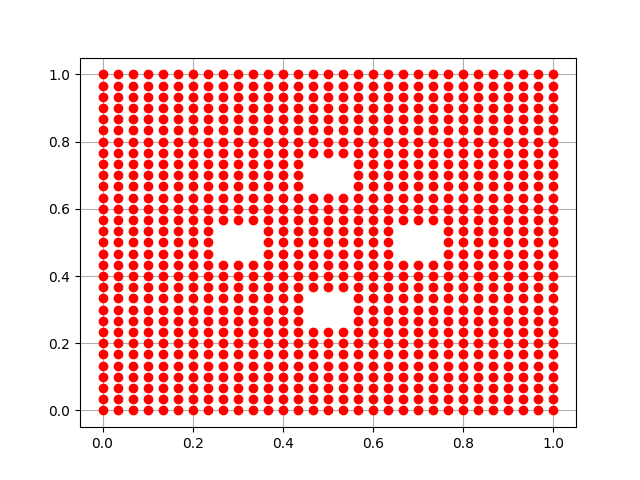

In [64]:
plt.close()
plt.plot(train_norm_labels[:,0], train_norm_labels[:,1], 'o', c = 'r', label = 'Normalized Training Data Labels')
plt.legend(loc='lower center', bbox_to_anchor=(1, -0.5))
plt.show()

##### Resample Training Data

In [78]:
train_resample = []

# create a dataframe from the normalized data
for i in range (0, len(training)):
    train_resample.append(pd.DataFrame(train_norm[i], columns = ['time', '1', '2', '3', '4']))
    # drop the time column
    train_resample[i] = train_resample[i].drop(columns = ['time'])

size = 100

for i in range (0, len(training)):
    train_resample[i] = resample(train_resample[i], size)

np.asarray(train_resample).shape

(925, 100, 4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
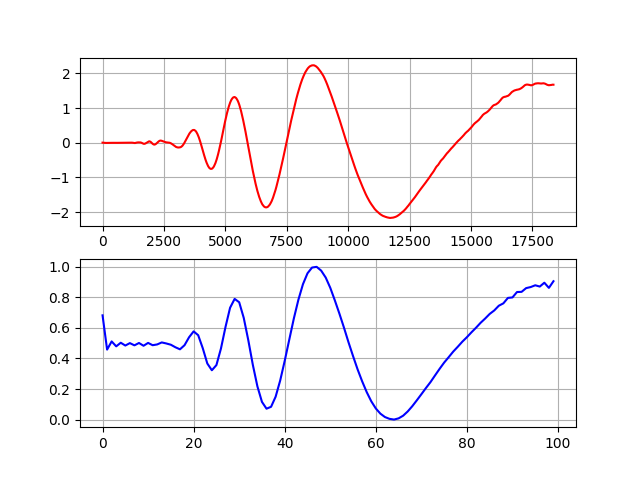

In [81]:
plt.close()
fig, axs = plt.subplots(2, 1)

axs[0].plot(train_cut[12][:,2], c = 'r')
axs[1].plot(train_resample[12][:,1], c = 'b')

plt.show()

#### Compare Experimental, Experimental-Validation and Training Data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
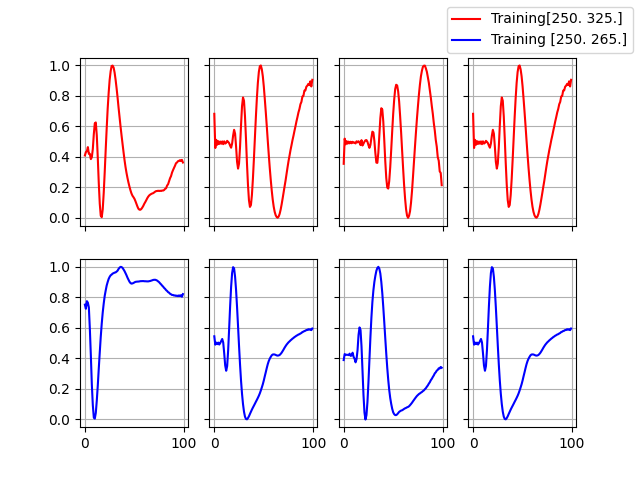

In [74]:
plt.close()
fig, axs = plt.subplots(2, 4, sharex = True, sharey=True)
axs[0, 0].plot(train_resample[12][:,0], c = 'r', label=f'Training{training_labels[12]}')
axs[0, 1].plot(train_resample[12][:,1], c = 'r')
axs[0, 2].plot(train_resample[12][:,2], c = 'r')
axs[0, 3].plot(train_resample[12][:,3], c = 'r')

axs[1, 0].plot(train_resample[3][:,0], c = 'b', label = f'Training {training_labels[3]}')
axs[1, 1].plot(train_resample[3][:,1], c = 'b')
axs[1, 2].plot(train_resample[3][:,2], c = 'b')
axs[1, 3].plot(train_resample[3][:,3], c = 'b')

fig.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
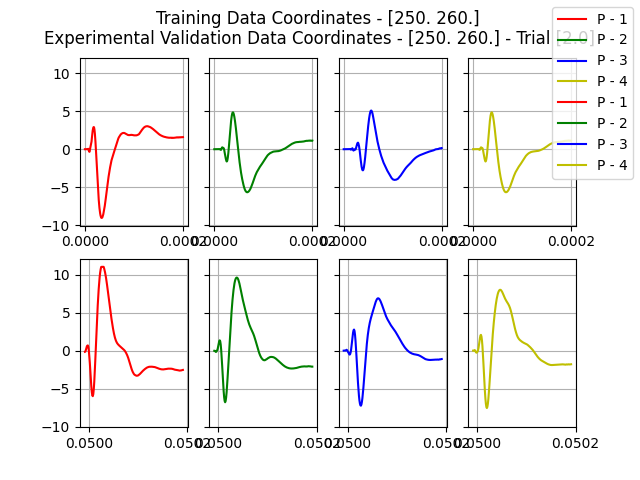

In [83]:
plt.close()
fig, axs = plt.subplots(2, 4, sharey=True)

ex_val_c = 17 # Given validation folder has 24 data points. so use - (0, 1, .... , 23)

# find out the index of the validation set in the training data
x = []
for i in range (0, len(training_labels)):
    if (training_labels[i][0] == ex_val_labels[ex_val_c][0]) and (training_labels[i][1] == ex_val_labels[ex_val_c][1]):
        x.append(i)

# plot to compare the validation set with the training set
fig.suptitle(f'Training Data Coordinates - {training_labels[x[0]]} \nExperimental Validation Data Coordinates - {ex_val_labels[ex_val_c]} - Trial [{ex_val_trails[ex_val_c]}]')

axs[0,0].plot(training[x[0]][:,0], training[x[0]][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training[x[0]][:,0], training[x[0]][:,2], label='P - 2', c = 'g')
axs[0,2].plot(training[x[0]][:,0], training[x[0]][:,3], label='P - 3', c = 'b')
axs[0,3].plot(training[x[0]][:,0], training[x[0]][:,4], label='P - 4', c = 'y')

axs[1,0].plot(ex_val_cut_data[ex_val_c][:,0], ex_val_cut_data[ex_val_c][:,1], label='P - 1', c = 'r')
axs[1,1].plot(ex_val_cut_data[ex_val_c][:,0], ex_val_cut_data[ex_val_c][:,2], label='P - 2', c = 'g')
axs[1,2].plot(ex_val_cut_data[ex_val_c][:,0], ex_val_cut_data[ex_val_c][:,3], label='P - 3', c = 'b')
axs[1,3].plot(ex_val_cut_data[ex_val_c][:,0], ex_val_cut_data[ex_val_c][:,4], label='P - 4', c = 'y')

fig.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
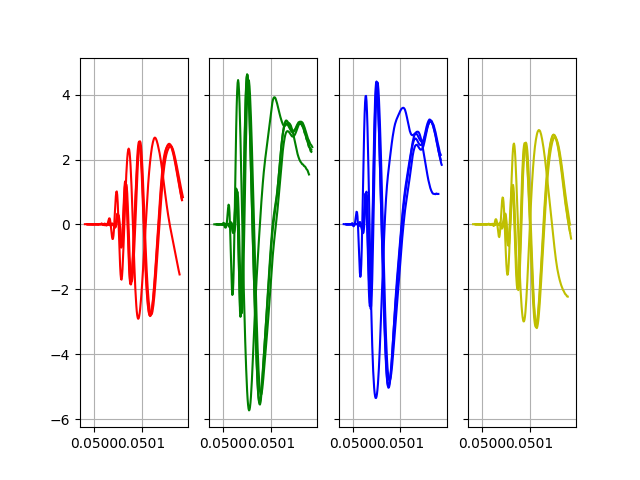

In [84]:
plt.close()
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
for i in range(4):
    axs[0].plot(ex_val_cut_data[i][:,0], ex_cut_data[i][:,1], c = 'r', label = 'Exp Val Data - P-1')
    axs[1].plot(ex_val_cut_data[i][:,0], ex_cut_data[i][:,2], c = 'g', label = 'Exp Val Data - P-2')
    axs[2].plot(ex_val_cut_data[i][:,0], ex_cut_data[i][:,3], c = 'b', label = 'Exp Val Data - P-3')
    axs[3].plot(ex_val_cut_data[i][:,0], ex_cut_data[i][:,4], c = 'y', label = 'Exp Val Data - P-4')

plt.show()

#### Export data to pickle

In [ ]:
# with open('training_data.pickle', 'wb') as f:
#     pickle.dump(training, f)

# with open('train_resample.pickle', 'wb') as f:
#     pickle.dump(train_resample, f)
# with open('train_norm_labels.pickle', 'wb') as f:
#     pickle.dump(train_norm_labels, f)

# with open('training_labels.pickle', 'wb') as f:
#     pickle.dump(training_labels, f)

# with open('exp_validation_data.pickle', 'wb') as f:
#     pickle.dump(ex_val_data, f)
# with open('exp_validation_labels.pickle', 'wb') as f:
#     pickle.dump(ex_val_labels, f)
# with open('exp_validation_trails.pickle', 'wb') as f:
#     pickle.dump(ex_val_trails, f)


# with open('exp_val_resample.pickle', 'wb') as f:
#     pickle.dump(ex_val_resample, f)
# with open('exp_val_norm_labels.pickle', 'wb') as f:
#     pickle.dump(ex_val_norm_labels, f)



#### AI Model

##### Split the data into training and testing sets

In [85]:
# Extract the data from the pickle files

'''
with open('train_resample.pickle', 'rb') as f:
    train_resample = pickle.load(f)
with open('train_norm_labels.pickle', 'rb') as f:
    train_norm_labels = pickle.load(f)
'''

X = np.asarray(train_resample)
y = np.asarray(train_norm_labels)

# create split data from the normalized data
size = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=size)
print(f'Length of training data - {len(x_train)} length of labels - {len(y_train)} \nLength of test data - {len(x_test)} and length of labels - {len(y_test)}')

Length of training data - 740 length of labels - 740 
Length of test data - 185 and length of labels - 185


##### TensorBoard

In [ ]:
%tensorboard --logdir=logs/

##### Model Training and Tuning

In [ ]:
'''
log_files = f'DNN_log.{int(time.time())}'
tuner_logs= f'tunelog/DNN_tuner_log.{int(time.time())}'

tensorboard = TensorBoard(log_dir=f'logs/{log_files}', 
                          histogram_freq=1, 
                          write_graph=True,
                          write_grads=True)


def dnnModel(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(100,4)))
    model.add(Dense(units=hp.Int('layer_1_nodes', 
                    min_value=32, max_value=512, step=32), 
                    activation=hp.Choice("activation_1", ["relu", "sigmoid", "tanh"])))
    
    for i in range(hp.Int('n_layers', min_value=0, max_value=4, step=1)):
        model.add(Dense(units=hp.Int(f'layer_{i+1}_nodes', min_value=32, max_value=512, step=32), activation=hp.Choice(f"activation_{i+1}", ["relu", "sigmoid", "tanh"])))
    
    model.add(Dense(units=2, activation=hp.Choice("activation_out", ['sigmoid', 'linear']))) # output layer

    model.summary()

    # Compile model
    # lr = hp.Float("lr", min_value=1e-4, max_value=1e-2)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)

    model.compile(loss = hp.Choice('loss', ['mae']),
                optimizer = hp.Choice('optimizer', ['Adam', 'RMSprop']), 
                metrics=['Accuracy'])
    
    return model

# Hyperparameter tuning
tuner = RandomSearch(dnnModel,
                    objective='val_Accuracy',
                    max_trials=50,
                    executions_per_trial=2,
                    directory=tuner_logs,
                    project_name='DNN_tuning')

tuner.search(x=x_train,
            y=y_train,
            epochs=60,
            batch_size=32,
            validation_data=(x_test, y_test),
            callbacks=[tensorboard])
            '''

In [ ]:
# bestModels = tuner.get_best_models(num_models=2)

In [ ]:
# Save the keras model
# model.save(f'model/complete_tunedModel_95perAcc.{int(time.time())}.h5')

#### DNN Model

In [86]:
model = Sequential()
model.add(Flatten(input_shape=(100,4)))

model.add(Dense(units=768, activation='relu'))

model.add(Dense(units=352, activation='relu'))

model.add(Dense(units=2, activation='linear'))

model.summary()

# Compile model
opt = tf.keras.optimizers.Adam(lr=0.0001)

model.compile(loss = 'mae', optimizer = opt, metrics=['Accuracy'])

# Fit the model
history = model.fit(x_train, y_train, epochs=50, verbose=1, batch_size=32, validation_data=(x_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 768)               307968    
                                                                 
 dense_1 (Dense)             (None, 352)               270688    
                                                                 
 dense_2 (Dense)             (None, 2)                 706       
                                                                 
Total params: 579,362
Trainable params: 579,362
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


C:\Users\sreekar\anaconda3\envs\ai\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 16ms/step - loss: 0.3534 - Accuracy: 0.4986 - val_loss: 0.2526 - val_Accuracy: 0.5514
Epoch 2/50
24/24 [==============================] - 0s 6ms/step - loss: 0.2300 - Accuracy: 0.6270 - val_loss: 0.2372 - val_Accuracy: 0.6324
Epoch 3/50
24/24 [==============================] - 0s 6ms/step - loss: 0.1935 - Accuracy: 0.7149 - val_loss: 0.1840 - val_Accuracy: 0.7730
Epoch 4/50
24/24 [==============================] - 0s 6ms/step - loss: 0.1562 - Accuracy: 0.8054 - val_loss: 0.1516 - val_Accuracy: 0.7676
Epoch 5/50
24/24 [==============================] - 0s 6ms/step - loss: 0.1277 - Accuracy: 0.8338 - val_loss: 0.1398 - val_Accuracy: 0.7784
Epoch 6/50
24/24 [==============================] - 0s 7ms/step - loss: 0.0984 - Accuracy: 0.8622 - val_loss: 0.1363 - val_Accuracy: 0.8270
Epoch 7/50
24/24 [==============================] - 0s 7ms/step - loss: 0.0844 - Accuracy: 0.8892 - val_loss: 0.1011 - val_Accuracy: 0.7892
Epoch 8/50
24/24 [============

In [ ]:
# model.save(f'model/val_acc_94perAcc.{int(time.time())}.h5')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
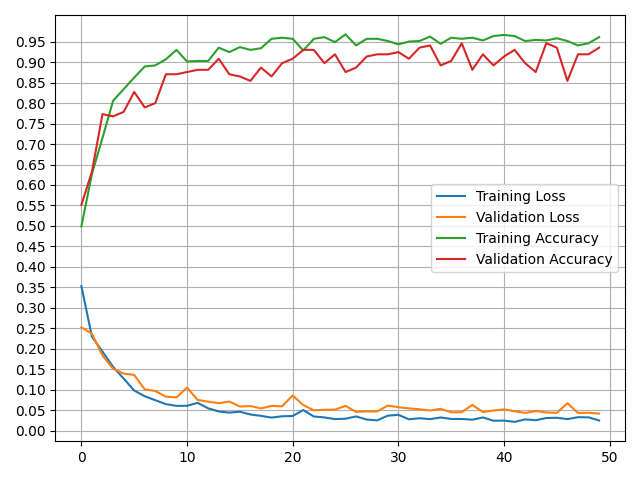

In [87]:
plt.close()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['Accuracy'], label='Training Accuracy')
plt.plot(history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))

plt.tight_layout()
plt.legend()
plt.show()

#### CNN Model

In [ ]:
cnn_model = Sequential()
# create a CNN cnn_model
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(100,4)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# cnn_model.add(MaxPooling1D(pool_size=2))
# cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=32, activation='relu'))
cnn_model.add(Dense(units=2, activation='linear'))
cnn_model.summary()


# Compile cnn_model
opt = tf.keras.optimizers.Adam(lr=0.0001)

cnn_model.compile(loss = 'mae', optimizer = opt, metrics=['Accuracy'])

# Fit the cnn_model
cnn_history = cnn_model.fit(x_train, y_train, epochs=125, verbose=1, batch_size=32, validation_data=(x_test, y_test))

In [ ]:
plt.close()
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.plot(cnn_history.history['Accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))

plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
# cnn_model = cnn_model.save(f'model/cnn_model_92perAcc.{int(time.time())}.h5')

#### SVR Model

In [ ]:
# with open('train_resample.pickle', 'rb') as f:
#     train_resample = pickle.load(f)

# with open('train_norm_labels.pickle', 'rb') as f:
#     train_norm_labels = pickle.load(f)

# with open('training_labels.pickle', 'rb') as f:
#     training_labels = pickle.load(f)

# X = train_resample
# y = training_labels

# scalar = MinMaxScaler()
# y_norm = scalar.fit_transform(training_labels)

# print(np.asarray(X).shape, np.asarray(y).shape)

# # create split data from the normalized data
# size = 0.15
# x_train, x_test, y_train, y_test = train_test_split(X, y_norm, shuffle=True, test_size=size)
# print(f'Length of training data - {np.asarray(x_train).shape} length of labels - {np.asarray(y_train).shape} \nLength of test data - {np.asarray(x_test).shape} and length of labels - {np.asarray(y_test).shape}')

In [95]:
x_train_flat = []
for i in range(len(x_train)):    
    x_dummy = np.asarray(x_train[i]).flatten()
    x_train_flat.append(x_dummy)
    
x_train_flat = np.asarray(x_train_flat)

x_test_flat = []
for i in range(len(x_test)):    
    x_dummy = np.asarray(x_test[i]).flatten()
    x_test_flat.append(x_dummy)
    
x_test_flat = np.asarray(x_test_flat)

print(np.asarray(x_train_flat).shape, np.asarray(y_train).shape)

(740, 400) (740, 2)


In [96]:
regr_multirf = MultiOutputRegressor(svm.SVR())
regr_multirf.fit(x_train_flat, y_train)

y_pred = regr_multirf.predict(x_test_flat)

In [97]:
y_pred = scalar.inverse_transform(y_pred)
y_test = scalar.inverse_transform(y_test)

y_test-y_pred

array([[ 1.49552984e+01,  1.58138434e+01],
       [-1.34447617e+00,  1.49930718e+01],
       [ 1.58195036e+01,  2.65787852e+00],
       [ 1.57198038e+01,  1.53427388e+01],
       [ 1.56969646e+01,  1.47125754e+01],
       [ 1.86388790e+01, -1.68158218e+01],
       [ 1.50824944e+01, -1.50363141e+01],
       [-1.52733486e+01, -9.43329261e+00],
       [-1.12904589e+01, -1.99644854e+01],
       [ 1.74654868e+01,  1.64140219e-01],
       [-1.71115980e+01, -2.25429900e+01],
       [ 2.30308340e+01,  1.63243846e+01],
       [-1.54326327e+01,  1.49978145e+01],
       [ 1.48574792e+01, -1.18041456e+01],
       [ 5.69067705e+00, -2.19937848e+01],
       [ 9.99502493e+00,  1.44320860e+01],
       [ 1.65981779e+01,  1.71781931e+01],
       [ 1.76231262e+01, -1.09429109e+01],
       [-2.40298170e+01, -1.80200589e+01],
       [-1.34572712e-01, -1.38131590e+01],
       [ 1.02075027e+01, -1.77972211e+01],
       [-9.55008777e+00,  1.45704746e+01],
       [-1.01031977e+01,  1.47563636e+01],
       [-1.

#### KNN Model

In [118]:
# with open('train_resample.pickle', 'rb') as f:
#     train_resample = pickle.load(f)

# with open('train_norm_labels.pickle', 'rb') as f:
#     train_norm_labels = pickle.load(f)

# with open('training_labels.pickle', 'rb') as f:
#     training_labels = pickle.load(f)

# with open('exp_val_resample.pickle', 'rb') as f:
#     exp_val_resample = pickle.load(f)

# with open('exp_val_norm_labels.pickle', 'rb') as f:
#     exp_val_labels = pickle.load(f)

X = train_resample
y = training_labels

exp_val_X = ex_val_resample
exp_val_y = ex_val_labels

scalar = MinMaxScaler()
y_norm = scalar.fit_transform(training_labels)

print(np.asarray(X).shape, np.asarray(y).shape)

# create split data from the normalized data
size = 0.1
x_train, x_test, y_train, y_test = train_test_split(X, y_norm, shuffle=True, test_size=size)
print(f'Length of training data - {np.asarray(x_train).shape} length of labels - {np.asarray(y_train).shape} \nLength of test data - {np.asarray(x_test).shape} and length of labels - {np.asarray(y_test).shape}')

(925, 100, 4) (925, 2)
Length of training data - (832, 100, 4) length of labels - (832, 2) 
Length of test data - (93, 100, 4) and length of labels - (93, 2)


In [120]:
x_train_flat = []
for i in range(len(x_train)):    
    x_dummy = np.asarray(x_train[i]).flatten()
    x_train_flat.append(x_dummy)
    
x_train_flat = np.asarray(x_train_flat)

x_test_flat = []
for i in range(len(x_test)):    
    x_dummy = np.asarray(x_test[i]).flatten()
    x_test_flat.append(x_dummy)
    
x_test_flat = np.asarray(x_test_flat)

exp_val_X_flat = []
for i in range(len(exp_val_X)):
    x_dummy = np.asarray(exp_val_X[i]).flatten()
    exp_val_X_flat.append(x_dummy)

exp_val_X_flat = np.asarray(exp_val_X_flat)

print(np.asarray(x_train_flat).shape, np.asarray(y_train).shape)
print(x_test_flat.shape, y_test.shape)
print(exp_val_X_flat.shape, exp_val_y.shape)

(832, 400) (832, 2)
(93, 400) (93, 2)
(24, 400) (24, 2)


In [122]:
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(x_train_flat, y_train)
y_pred = knn.predict(x_test_flat)

In [123]:
y_pred = scalar.inverse_transform(y_pred)
y_test = scalar.inverse_transform(y_test)

y_test-y_pred

array([[-9.82169938e-01,  5.92672597e-01],
       [ 9.08756215e-01,  1.16306286e-02],
       [-1.01077549e+00,  2.51023494e-02],
       [ 8.79493508e-01, -1.77357591e+00],
       [ 9.00087533e-02,  1.10126434e+00],
       [ 0.00000000e+00,  1.81055965e+00],
       [-3.65328438e-02, -1.09649568e+00],
       [-1.17811953e-01,  8.98039611e-01],
       [ 1.43634245e+00,  4.72779598e-01],
       [ 3.96794234e-02,  8.17130776e-01],
       [ 7.83062780e-01, -9.03218753e-01],
       [ 5.97323444e-01, -8.03517334e-01],
       [-8.20728341e-01,  7.32283373e-01],
       [-4.53121172e+00,  4.57799873e+00],
       [-7.98484965e-01,  1.51352728e-01],
       [ 6.36468021e+00, -3.73079219e+00],
       [-2.10836418e+00,  3.26864984e+01],
       [-9.63302745e+00, -1.58701141e+00],
       [ 8.59633997e-01, -8.69084367e-01],
       [-8.81150369e-01, -5.33893037e-01],
       [ 8.44412310e-01,  7.95124300e-01],
       [ 6.42631390e-01, -4.08766466e-01],
       [-1.65104796e+00,  2.45263195e+00],
       [-1.

In [124]:
y_pred_exp = knn.predict(exp_val_X_flat)
y_pred_exp = scalar.inverse_transform(y_pred_exp)

exp_val_y-y_pred_exp

array([[ -1.44574717, -24.69009699],
       [ -9.25546952, -21.75243912],
       [-11.67278562, -27.37555438],
       [ -0.54051984, -25.58689493],
       [  7.08672245, -19.92197844],
       [ 11.0026885 , -18.96334982],
       [ 11.97804371,  -9.9524077 ],
       [ 11.03918831, -21.8838876 ],
       [-39.13434732, -31.55444225],
       [-40.71174262,  -9.96415168],
       [-39.06926367, -32.18175202],
       [-27.4273993 , -52.16492028],
       [ 24.27841573,  17.73320921],
       [-44.09494467,  29.79604388],
       [-18.86412206,  14.88786082],
       [-31.72802443,  19.53120414],
       [  9.13139908,  20.05089168],
       [ -1.07891832,  11.02534398],
       [ -3.91222519,  14.90876407],
       [  8.9259698 ,  20.02327858],
       [ -6.00979207,  -1.91777618],
       [ -1.25576868,   2.38930074],
       [ -1.21234686,  -1.63244324],
       [ -6.04692546,  -1.79981938]])

#### Predict experimental data validation

In [92]:
# model = tf.keras.models.load_model('model/tunedModel_98perAcc.1640573960.h5')
# model = tf.keras.models.load_model('model/val_acc_94perAcc.1641231353.h5')
# model = tf.keras.models.load_model('model/95perAcc.1640511698.h5')


In [93]:
y_pred = model.predict(np.asarray(ex_val_resample))
y_abs = ex_val_labels
y_pred = scalar.inverse_transform(np.asarray(y_pred))

In [94]:
for i in range(len(y_pred)):
    print(f'Absolute Trial {ex_val_trails[i]}- {y_abs[i]} Predicted - {y_pred[i]} \tDifference - {y_abs[i] - y_pred[i]}')

Absolute Trial 1.0- [205. 200.] Predicted - [215.91745 206.7551 ] 	Difference - [-10.91744995  -6.75509644]
Absolute Trial 2.0- [205. 200.] Predicted - [218.06418 198.02454] 	Difference - [-13.06417847   1.97546387]
Absolute Trial 3.0- [205. 200.] Predicted - [201.24261 200.54312] 	Difference - [ 3.75738525 -0.54312134]
Absolute Trial 4.0- [205. 200.] Predicted - [215.09795 213.05795] 	Difference - [-10.09794617 -13.05795288]
Absolute Trial 1.0- [225. 210.] Predicted - [205.80365 252.30737] 	Difference - [ 19.1963501  -42.30737305]
Absolute Trial 2.0- [225. 210.] Predicted - [191.07211 228.43747] 	Difference - [ 33.92788696 -18.43746948]
Absolute Trial 3.0- [225. 210.] Predicted - [195.95987 238.03145] 	Difference - [ 29.04013062 -28.03144836]
Absolute Trial 4.0- [225. 210.] Predicted - [199.98418 242.42374] 	Difference - [ 25.01582336 -32.42373657]
Absolute Trial 1.0- [230. 245.] Predicted - [260.69806 309.39078] 	Difference - [-30.69805908 -64.39077759]
Absolute Trial 2.0- [230. 245.

#### -- Check -- prediction for augmentation validation data

In [90]:
c = []
checking1 = validation_aug[0][:,1:5]
checking1 = minmax_scale(checking1)
checking1 = resample(checking1, 100)

checking2 = validation_aug[1][:,1:5]
checking2 = minmax_scale(checking2)
checking2 = resample(checking2, 100)

checking3 = validation_aug[2][:,1:5]
checking3 = minmax_scale(checking3)
checking3 = resample(checking3, 100)

checking4 = validation_aug[3][:,1:5]
checking4 = minmax_scale(checking4)
checking4 = resample(checking4, 100)

c.append(checking1)
c.append(checking2)
c.append(checking3)
c.append(checking4)

'''
plt.close()
plt.title(f'Validation Data {validation_aug_labels[0]}')
plt.plot(checking1[:,0], label = 'P - 1')
plt.plot(checking1[:,1], label = 'P - 2')
plt.plot(checking1[:,2], label = 'P - 3')
plt.plot(checking1[:,3], label = 'P - 4')
plt.legend()
plt.show()
'''

"\nplt.close()\nplt.title(f'Validation Data {validation_aug_labels[0]}')\nplt.plot(checking1[:,0], label = 'P - 1')\nplt.plot(checking1[:,1], label = 'P - 2')\nplt.plot(checking1[:,2], label = 'P - 3')\nplt.plot(checking1[:,3], label = 'P - 4')\nplt.legend()\nplt.show()\n"

In [91]:
print(f'{validation_aug_labels[0]} \n{validation_aug_labels[1]} \n{validation_aug_labels[2]} \n{validation_aug_labels[3]}')

p = model.predict(np.asarray(c))
p = scalar.inverse_transform(p)
print(p)

error = []
for i in range(0, len(p)):
    a = validation_aug_labels[i][0]-p[i][0]
    b = validation_aug_labels[i][1]-p[i][1]
    e = [a, b]
    error.append(e)

print(f'Difference between the actual and predicted coordinates: \n{np.asarray(error)}')

[225. 235.] 
[225. 265.] 
[275. 235.] 
[275. 265.]
[[221.17947 239.1107 ]
 [233.96124 261.02075]
 [279.5551  229.40524]
 [282.65146 271.4298 ]]
Difference between the actual and predicted coordinates: 
[[ 3.82052612 -4.11070251]
 [-8.96124268  3.97924805]
 [-4.55511475  5.59475708]
 [-7.65145874 -6.42980957]]
